# Contents
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Preliminary EDA](#EDA)
- [Model Interpretation](#Model-Interpretation)
- [Choose The Best Model](#Choose-The-Best-Model)
- [Conclusion](#Conclusion)
- [Tester](#Tester-(BONUS))

# Problem Statement

We at T-mobile, would like to make sure that only posts that are meant for T-mobile are put up on our website. <br>
We have seen a bunch of posts that are meant for sprint popping up on our pages. <br>
To combat this issue we would like to create a model that can make sure that no verizon posts go up on our site.<br>
In order to test our models, we decided to pull data from reddit.

# Executive Summary

We were approached with the task of building a prediction model. This model is meant to take in an post and determine whether it is meant for T-Mobile or not.<br>
We at T-mobile really value our customers and we only want them to see posts that are meant for them to see and not spam from other websites.<br>
We would like our model to be as accurate as possible in predicting whether a post belongs to T-mobile or not.<br>

We decided to use reddit posts to create our model. We designed a web-scraping tool to go and pull around 1000 posts from both the T-mobile subreddit and the Verizon subreddit.<br>

The posts were very messy and filled with data that we do not want such as random punctuation, white space, and special characters.<br>
We cleaned the posts and came across another issue, there were many words in the data that were either words that have no value to our model, or words that are essentially the same root such as (cook, cooking, cooks...).<br>
First, we removed all of these meaningless "stop words", then we also removed words that would be too obvious for our model such as "tmobile" or "Comcast".
We used a device called a 'lemmatizer'. This device goes through each word and tries to bring it down to the root of each word.<br>
Once our posts were done being lemmatized, we were able to move to the next step.<br>

There are many different ways to prepare the data for these Natural Language Processing (NLP) models. <br>
Because of this, we decided to run a bunch of combinations of models and classifiers and create a grid with each combination and it's respective scores.<br>
These combinations were also run through a GridSearch function which checked for the best parameters for each model.<br>
Once we ran all of our models, we looked through them all to find whichever model best fit our problem.<br>

Once we chose the best fit model, we decided to make a function that lets you input text and tells you whether it is a part of the t-mobile subreddit or sprint.<br>
This is helpful as it would be a way for us to show off the accuracy of our model.



# Data Import and Cleaning

### Import Libraries

In [1]:
import JacksModelPipeline

In [22]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import requests.auth
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_spli t
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,recall_score,precision_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import re
from nltk.tokenize import punkt

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Gather Data

#### Get Reddit API Key

In [500]:
client_auth = requests.auth.HTTPBasicAuth('KYJF2TlfdLIPVA', '6WaEAs-CMmPwjBQUelKxC3bXgHs')
post_data = {"grant_type": "password", "username": "jbibi1296", "password": "577V2h7pgfpvYc2"}
headers = {"User-Agent": "ChangeMeClient/0.1 by jbibi1296"}
response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
response.json()
params = {}
headers = {"Authorization": (f"bearer {response.json()['access_token']}"), "User-Agent": "ChangeMeClient/0.1 by jbibi1296"}
res = requests.get("https://oauth.reddit.com/api/v1/me", headers=headers, params = params)
response.json()




{'access_token': '32566353-hSenBJch__L_ouULCUS8Ofzk3gE',
 'token_type': 'bearer',
 'expires_in': 3600,
 'scope': '*'}

#### Check features in JSON File

In [501]:
client_auth = requests.auth.HTTPBasicAuth('KYJF2TlfdLIPVA', '6WaEAs-CMmPwjBQUelKxC3bXgHs')
post_data = {"grant_type": "password", "username": "jbibi1296", "password": "577V2h7pgfpvYc2"}
headers = {"User-Agent": "ChangeMeClient/0.1 by jbibi1296"}
response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
response.json()
headers = {"Authorization": ('bearer {}'.format(response.json()['access_token'])),"User-Agent": "ChangeMeClient/0.1 by jbibi1296"}
url = f'https://oauth.reddit.com/r/baseball.json?'
res = requests.get(url, headers=headers)
for i in res.json()['data']['children'][2]['data']:
    print(i,':',res.json()['data']['children'][2]['data'][i])
    print("=============================================")

approved_at_utc : None
subreddit : baseball
selftext : 
author_fullname : t2_12jdd9
saved : False
mod_reason_title : None
gilded : 0
clicked : False
title : Inquiring minds want to know
link_flair_richtext : [{'e': 'text', 't': 'Image'}]
subreddit_name_prefixed : r/baseball
hidden : False
pwls : 6
link_flair_css_class : img
downs : 0
thumbnail_height : 140
hide_score : False
name : t3_b9qj7l
quarantine : False
link_flair_text_color : dark
author_flair_background_color : 
subreddit_type : public
ups : 6839
domain : i.imgur.com
media_embed : {}
thumbnail_width : 140
author_flair_template_id : None
is_original_content : False
user_reports : []
secure_media : None
is_reddit_media_domain : False
is_meta : False
category : None
secure_media_embed : {}
link_flair_text : Image
can_mod_post : False
score : 6839
approved_by : None
thumbnail : https://b.thumbs.redditmedia.com/qAPvuI_wnEusO87LMfasqoPb6PNgGdFzH2WROcMZa9g.jpg
edited : False
author_flair_css_class : det-1
author_flair_richtext : [{'e

In [502]:
import praw

reddit = praw.Reddit(client_id='KYJF2TlfdLIPVA',
                     client_secret='6WaEAs-CMmPwjBQUelKxC3bXgHs',
                     user_agent='Jbib')

import pandas as pd
def get_reddit(subreddits):
    post = []
    subreddit = []
    for submission in reddit.subreddit(subreddits).hot(limit=1000):
        if type(submission.selftext == str):
            post.append(submission.title+submission.selftext)
        else:
            post.append(submission.title)
        subreddit.append(submission.subreddit)
    postsss = pd.DataFrame(post)
    postsss['post'] = post
    postsss['subreddit'] = subreddit
    postsss = postsss[['post','subreddit']]
    postsss.to_csv(f'../Data/{subreddits}_posts.csv',index = None)
    return postsss.head()
    



In [503]:
get_reddit('tmobile')


KeyboardInterrupt: 

In [ ]:
get_reddit('comcast')

### Read In The Data

In [504]:
all_first = pd.read_csv('../Data/tmobile_posts.csv')
all_second = pd.read_csv('../Data/comcast_posts.csv')




# EDA

### Make Data Frame Of All Posts In A Subreddit

In [505]:
all_df = pd.merge(all_first,all_second,how = 'outer')

## Binarize the Subreddit Column 
- 1 if T-mobile
- 0 if Comcast

In [506]:
all_df['subreddit'] = all_df['subreddit'].map(lambda x: 1 if x == 'tmobile' else 0)


#### Export our subreddit Data Frame
(In case we want to work on it later)

In [507]:
all_df.to_csv('../Data/all_reddit_posts.csv',index=None)

#### Re-import our subreddit Data Frame

In [508]:
all_df = pd.read_csv('../Data/all_reddit_posts.csv',)

#### Create a list of punctuations that we want removed

In [509]:
punct = ['`','~','!','@','#','$','%','^','&','*','(',')','-','_','=','+','[','{',']','}','\\','|',';',':','\'','"',',','<','.','>','/','?']

#### Import NLP  cleaning Libraries

In [510]:

from nltk.tokenize import sent_tokenize, word_tokenize
import string
import re
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

#### Remove Punctuation, stop words, and other words that we do not want in our data set

In [511]:
# Create an empty list
lists = []

# For Loop to go through each post
for i in all_df.post:
    
    # Make each post lowercase, remove digits, take away white space
    i = i.lower()
    i = re.sub(r'\d+', '', i)
    i = i.strip()
    
    # Take away all punctuation
    for letter in i:
        if letter in punct:
            i.replace(letter,'')
            
    # Tokenize
    tokens = word_tokenize(i)
    
    # Remove stop words
    tokens = [j for j in tokens if not j in (STOP_WORDS.union(['www', 'things', 'does', 'x200b', 'amp','just', 'like', 'https', 'com',"ve","didn't","n't",'tmobile','comcast','says', 'say', 'like', 'did', 'this']))]
    
    # Remove words with less than 3 letters
    tokens = [j for j in tokens if len(j) >2]
    
    # Combine all tokens to one post
    strings = ' '
    strings = strings.join(tokens)
    
    # Add string to empty list
    lists.append(strings)

#Push list of strings back into the Data Frame
all_df['post'] = lists

# View the first 5 rows
all_df.head()

,post,subreddit
0,sim card ripoffevery time t-mobile tell import...,1
1,interesting article sprint fail merger,1
2,yeah..,1
3,effective lately 've getting number calls late...,1
4,message count usage overviewi know details por...,1


#### Bring each word down to it's root word

In [512]:
# Instantiate the Lemmatizer
lemmatizer=WordNetLemmatizer()

# Create an empty list
post = []

# For loop to go through each post in the Data Frame
for i in all_df.post:
    
    #Tokenize each word 
    words=word_tokenize(i)
    
    #create an empty list
    lemm =[]
    
    #Loop through each tokenized word and lemmatize it
    for word in words:
        lemm.append(lemmatizer.lemmatize(word))
    
    # Remove words with less than 3 letters
    lemm = [word for word in lemm if len(word)>2]
    
    # Add the lemmatized words back together as a string
    strings = ' '
    strings = strings.join(lemm)
    
    # Add the string to a list
    post.append(strings)
    
# Add the list of lemmatized strings back to the Data Frame    
all_df['post'] = post

# View the first 5 rows
all_df.head()





,post,subreddit
0,sim card ripoffevery time t-mobile tell import...,1
1,interesting article sprint fail merger,1
2,yeah..,1
3,effective lately 've getting number call latel...,1
4,message count usage overviewi know detail port...,1


# Model Interpretation

### Setting X and y variables

In [513]:
X = all_df[['post']]
y = all_df['subreddit']

Created a class that can take in vectorizer & models with their respective parameters <br> 
Then, it will plug all of the models into a pipeline and it will gridsearch for the best parameters.<br>
Once all of the models are run, it will print a data frame that includes:
  - All of the combinations of Classifiers and Vectorizer
  - The best parameters from the gridsearch
  - The Accuracy scores for the Testing and Training Data
  - The Precision scores for the Testing and Training Data
  - The Recall scores for the Testing and Training Data
  - The Specificity scores for the Testing and Training Data


In [514]:
class JackModelPipeline:
    def __init__(self,X,y):
        self.y = y
        self.X = X
        self.vec_params={}
        self.clf_params={}
        self.clasf = []
        self.clasf_string = []
        self.vecs = []
        self.vecs_string = []
        
    def import_libraries(self):
        import requests
        from bs4 import BeautifulSoup
        import time
        import pandas as pd
        import numpy as np
        import requests.auth
        import datetime
        from sklearn.linear_model import LogisticRegression
        from sklearn.model_selection import GridSearchCV, train_test_split
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.pipeline import Pipeline
        from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.naive_bayes import MultinomialNB
        from sklearn.metrics import accuracy_score,recall_score,precision_score, confusion_matrix
        from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier
        from sklearn.svm import SVC
        import re
        from nltk.tokenize import punkt
        
    def add_clf(self,clf,string,params):
        self.clasf.append(clf)
        self.clasf_string.append(string)
        self.clf_params[string]=params  
            
    def add_vec(self,vec,string,params):
        self.vecs.append(vec)
        self.vecs_string.append(string)
        self.vec_params[string]=params  
            
    def show_clf_list(self):
        return self.clasf,self.clasf_string,self.clf_params

    def show_vec_list(self):
        return self.vecs,self.vecs_string,self.vec_params
    
    def show_params(self):
        return self.vec_params,self.clf_params
    
    def run_pipe(self):
        
        lists = []
        
        
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y, stratify = y,test_size=.2)
        
        number = 0
        for num_vec,vectorizer in enumerate(self.vecs):
            for num_clas,classifier in enumerate(self.clasf):

                #Create an empty dictionary to add to the dataframe
                dic = {}
                pipe_params = {}
                
                # Chooses the parameters based on whichever classifiers and vectorizers are being passed through
                vec_dict = self.vec_params[self.vecs_string[num_vec]]
                clasf_dict = self.clf_params[self.clasf_string[num_clas]]
                pipe_params.update(vec_dict)
                pipe_params.update(clasf_dict)

                # Create the Pipeline 
                pipe = Pipeline([(f'{self.vecs_string[num_vec]}',vectorizer),
                                 ((f'{self.clasf_string[num_clas]}',classifier))
                                ])
                
                # Set up the Grid Search
                gridvec = GridSearchCV(pipe,
                                       param_grid = pipe_params,
                                       cv=3,
                                       n_jobs = 5,
                                       verbose = 1)
                
                # Fit the GridSearch
                gridvec.fit(X_train,y_train)
                
                #Take the Best estimator
                bestest = gridvec.best_estimator_

                # Fit and transform the data on the best estimator
                bestest.fit(X_train,y_train)
                
                # save the classifier name, vectorizer name, and best parameters
                dic['classifier'] = self.clasf_string[num_clas]
                dic['vectorizer'] = self.vecs_string[num_vec]
                dic['Best_Params'] = gridvec.best_params_

                # Create the predictions for Y Train and Test data
                train_preds = bestest.predict(X_train)
                test_preds = bestest.predict(X_test)
                
                # Find the accuracy, precision, recall (Sensitivity) and specificity for both the Train Data and Test Data
                dic['train_accuracy'] = accuracy_score(y_train,train_preds)
                dic['test_accuracy'] = accuracy_score(y_test,test_preds)
                
                dic['train_precision'] = precision_score(y_train,train_preds,average='weighted')
                dic['test_precision'] = precision_score(y_test,test_preds,average='weighted')
                
                dic['train_recall'] = recall_score(y_train,train_preds,average='weighted')
                dic['test_recall'] = recall_score(y_test,test_preds,average='weighted')
                
                tn,fp,fn,tp  = confusion_matrix(y_train,train_preds).ravel()
                dic['train_specificity'] = tn/(tn+fp)
                tn,fp,fn,tp  = confusion_matrix(y_test,test_preds).ravel()
                dic['test_specificity'] = tn/(tn+fp)

                # Add the dictionary to a list
                lists.append(dic)
                
                # Let you know where you are up to 
                number +=1
                print(f'Done with {number} out of {(len(self.vecs)*len(self.clasf))} models.')

        # Transform the list to a Data Frame
        self.clf_df = pd.DataFrame(data = lists)
    def ShowGrid(self):
        return self.clf_df

        

### Testing out all Models

#### Importing the custom class

In [515]:
# Import the custom class that I created
import JacksModelClass 

#### - Instantiating Class
#### - Add Vectorizer
 - Format is (Vectorizer, 'Vectorizer', Dictionary of parameters as if it was in a pipeline gridsearch)
 
#### - Add Classifier
 - Format is (Classifier, 'Classifier', Dictionary of parameters as if it was in a pipeline gridsearch)
 
#### - Run The Pipelines

In [516]:

# Instantiate the class with X and Y variable
jj = JackModelPipeline(all_df['post'],all_df['subreddit'])

# Add Vectorizers to the model with their dictionary hyper-parameters to perform a GridSearch on
jj.add_vec(HashingVectorizer(non_negative=True),'HashingVectorizer',{})
jj.add_vec(CountVectorizer(),'CountVectorizer',{ 
                                    'CountVectorizer__max_features': [100,1000,7000,None],
                                    'CountVectorizer__min_df': [4],
                                    'CountVectorizer__ngram_range': [(1,1),(1,2)],
                                    })
jj.add_vec(TfidfVectorizer(),'TfidfVectorizer',{
                                    'TfidfVectorizer__max_features': [100,500,1000],
                                    'TfidfVectorizer__min_df': [4],
                                    'TfidfVectorizer__ngram_range': [(1,1),(1,2)]
                                    })

# Add Classifiers to the model with their dictionary hyper-parameters to perform a GridSearch on
jj.add_clf(LogisticRegression(),'LogisticRegression',{'LogisticRegression__penalty': ['l1','l2']})
jj.add_clf(MultinomialNB(),'MultinomialNB',{})

jj.add_clf(SVC(),'SVC',{'SVC__kernel':['sigmoid','rbf'],
                       'SVC__gamma':['auto']})
jj.add_clf(AdaBoostClassifier(),'AdaBoostClassifier',{})

jj.add_clf(GradientBoostingClassifier(),'GradientBoostingClassifier',{'GradientBoostingClassifier__n_estimators': [150],
                                                                     'GradientBoostingClassifier__max_depth':[4],
                                                                     'GradientBoostingClassifier__learning_rate':[.1],
                                                                      'GradientBoostingClassifier__subsample':[1.0],
                                                                     'GradientBoostingClassifier__min_samples_split':[3]})

# Run the pipeline
jj.run_pipe()

# Save the DataFrame under a variable name
model_df = jj.ShowGrid()

#look at the Data Frame
model_df

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/e

Done with 1 out of 15 models.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/e

Done with 2 out of 15 models.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/e

Done with 3 out of 15 models.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/e

Done with 4 out of 15 models.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/e

Done with 5 out of 15 models.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    2.2s finished


Done with 6 out of 15 models.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:    1.5s finished


Done with 7 out of 15 models.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    5.3s finished


Done with 8 out of 15 models.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:    1.6s finished


Done with 9 out of 15 models.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:    3.8s finished


Done with 10 out of 15 models.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed:    1.7s finished


Done with 11 out of 15 models.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done   9 out of  18 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    1.0s finished


Done with 12 out of 15 models.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed:    3.7s finished


Done with 13 out of 15 models.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    1.5s finished


Done with 14 out of 15 models.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    3.8s finished


Done with 15 out of 15 models.


,Best_Params,classifier,test_accuracy,test_precision,test_recall,test_specificity,train_accuracy,train_precision,train_recall,train_specificity,vectorizer
0,{'LogisticRegression__penalty': 'l2'},LogisticRegression,0.921466,0.922794,0.921466,0.899497,0.972495,0.972632,0.972495,0.982434,HashingVectorizer
1,{},MultinomialNB,0.900524,0.911552,0.900524,0.984925,0.938441,0.943832,0.938441,0.994981,HashingVectorizer
2,"{'SVC__gamma': 'auto', 'SVC__kernel': 'sigmoid'}",SVC,0.520942,0.271381,0.520942,1.000000,0.521938,0.272420,0.521938,1.000000,HashingVectorizer
3,{},AdaBoostClassifier,0.897906,0.902283,0.897906,0.854271,0.931238,0.935480,0.931238,0.888331,HashingVectorizer
4,{'GradientBoostingClassifier__learning_rate': ...,GradientBoostingClassifier,0.916230,0.916313,0.916230,0.914573,1.000000,1.000000,1.000000,1.000000,HashingVectorizer
5,"{'CountVectorizer__max_features': 1000, 'Count...",LogisticRegression,0.918848,0.921021,0.918848,0.889447,0.990832,0.990836,0.990832,0.989962,CountVectorizer
6,"{'CountVectorizer__max_features': 1000, 'Count...",MultinomialNB,0.939791,0.939860,0.939791,0.949749,0.949574,0.949592,0.949574,0.956085,CountVectorizer
7,"{'CountVectorizer__max_features': 1000, 'Count...",SVC,0.863874,0.885258,0.863874,0.758794,0.886706,0.901098,0.886706,0.803011,CountVectorizer
8,"{'CountVectorizer__max_features': 7000, 'Count...",AdaBoostClassifier,0.869110,0.877943,0.869110,0.804020,0.921415,0.925072,0.921415,0.882058,CountVectorizer
9,"{'CountVectorizer__max_features': 1000, 'Count...",GradientBoostingClassifier,0.918848,0.919047,0.918848,0.934673,0.971840,0.972783,0.971840,0.994981,CountVectorizer


# Choose The Best Model

### Highlight the models that performed best

In [531]:
# Function to highlight the max numbers in the columns
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Get the numerical columns 
num_col = model_df._get_numeric_data().columns

# Only get the columns that have the word 'test' in them
num_col = [i for i in model_df._get_numeric_data().columns if 'test' in i]

# Show me the max cells in the 'test' columns
model_df.style.apply(highlight_max,subset=num_col)

,Best_Params,classifier,test_accuracy,test_precision,test_recall,test_specificity,train_accuracy,train_precision,train_recall,train_specificity,vectorizer
0,{'LogisticRegression__penalty': 'l2'},LogisticRegression,0.921466,0.922794,0.921466,0.899497,0.972495,0.972632,0.972495,0.982434,HashingVectorizer
1,{},MultinomialNB,0.900524,0.911552,0.900524,0.984925,0.938441,0.943832,0.938441,0.994981,HashingVectorizer
2,"{'SVC__gamma': 'auto', 'SVC__kernel': 'sigmoid'}",SVC,0.520942,0.271381,0.520942,1,0.521938,0.27242,0.521938,1,HashingVectorizer
3,{},AdaBoostClassifier,0.897906,0.902283,0.897906,0.854271,0.931238,0.93548,0.931238,0.888331,HashingVectorizer
4,"{'GradientBoostingClassifier__learning_rate': 0.1, 'GradientBoostingClassifier__max_depth': 4, 'GradientBoostingClassifier__min_samples_split': 3, 'GradientBoostingClassifier__n_estimators': 150, 'GradientBoostingClassifier__subsample': 1.0}",GradientBoostingClassifier,0.91623,0.916313,0.91623,0.914573,1,1,1,1,HashingVectorizer
5,"{'CountVectorizer__max_features': 1000, 'CountVectorizer__min_df': 4, 'CountVectorizer__ngram_range': (1, 2), 'LogisticRegression__penalty': 'l2'}",LogisticRegression,0.918848,0.921021,0.918848,0.889447,0.990832,0.990836,0.990832,0.989962,CountVectorizer
6,"{'CountVectorizer__max_features': 1000, 'CountVectorizer__min_df': 4, 'CountVectorizer__ngram_range': (1, 2)}",MultinomialNB,0.939791,0.93986,0.939791,0.949749,0.949574,0.949592,0.949574,0.956085,CountVectorizer
7,"{'CountVectorizer__max_features': 1000, 'CountVectorizer__min_df': 4, 'CountVectorizer__ngram_range': (1, 1), 'SVC__gamma': 'auto', 'SVC__kernel': 'sigmoid'}",SVC,0.863874,0.885258,0.863874,0.758794,0.886706,0.901098,0.886706,0.803011,CountVectorizer
8,"{'CountVectorizer__max_features': 7000, 'CountVectorizer__min_df': 4, 'CountVectorizer__ngram_range': (1, 2)}",AdaBoostClassifier,0.86911,0.877943,0.86911,0.80402,0.921415,0.925072,0.921415,0.882058,CountVectorizer
9,"{'CountVectorizer__max_features': 1000, 'CountVectorizer__min_df': 4, 'CountVectorizer__ngram_range': (1, 2), 'GradientBoostingClassifier__learning_rate': 0.1, 'GradientBoostingClassifier__max_depth': 4, 'GradientBoostingClassifier__min_samples_split': 3, 'GradientBoostingClassifier__n_estimators': 150, 'GradientBoostingClassifier__subsample': 1.0}",GradientBoostingClassifier,0.918848,0.919047,0.918848,0.934673,0.97184,0.972783,0.97184,0.994981,CountVectorizer


# Conclusion
#### Based on Different Metrics

In [532]:
List = []

for col in model_df.columns:
    if 'test' in col:
        for i in model_df[col].index:
            if model_df[col][i] == max(model_df[col]):
                dic = {key:value for key,value in zip(model_df.loc[i].T[[0,5,6,7,8,9,1,2,3,4,10]].keys(),model_df.loc[i].T[[0,5,6,7,8,9,1,2,3,4,10]])}
                List.append(dic)
max_df = pd.DataFrame(List)

max_df = max_df.T.rename({0:'Max Accuracy',1:'Max Precision',2:'Max Recall',3:'Max Specificity'},axis=1)
max_df['Max Accuracy'][0]


{'CountVectorizer__max_features': 1000,
 'CountVectorizer__min_df': 4,
 'CountVectorizer__ngram_range': (1, 2)}

In [533]:
cvec = CountVectorizer(max_features= None)
X = all_df['post']
y = all_df['subreddit']

In [598]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y, random_state = 23)
X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)
mnb = MultinomialNB()
mnb.fit(X_train_vec,y_train)
y_preds = mnb.predict(X_test_vec)
Check_df = pd.DataFrame(X_test)
Check_df['subreddit'] = y_test
Check_df['guess'] = y_preds
miss = []
for i in Check_df.index:
        if Check_df.subreddit[i] != Check_df.guess[i]:
            miss.append(Check_df['post'][i])
        
cv = CountVectorizer(max_features= None)
misss = cv.fit_transform(miss)
pd.DataFrame(misss.todense(),columns=cv.get_feature_names()).sum().sort_values(ascending = False)

phone        20
xfinity      17
month        15
service      14
rep          12
account      10
tax          10
support       9
sir           9
plan          9
mobile        8
pay           8
data          8
email         7
new           7
issue         7
charged       6
day           6
text          6
number        6
minute        6
message       6
getting       6
know          6
job           6
use           5
current       5
got           5
signal        5
card          5
             ..
recipient     1
remote        1
removing      1
point         1
plz           1
planning      1
opened        1
nicer         1
no            1
note          1
notice        1
noticed       1
october       1
offer         1
offering      1
one           1
online        1
opening       1
place         1
ordered       1
org           1
page          1
paid          1
parent        1
park          1
perfect       1
permanent     1
pic           1
ping          1
louisiana     1
Length: 528, dtype: int6

In [537]:
print('Train Score:',mnb.score(X_train_vec,y_train))
print('Test Score:',mnb.score(X_test_vec,y_test))


Train Score: 0.977079240340537
Test Score: 0.9450261780104712


In [539]:
cvec_df = pd.DataFrame(X_train_vec.todense(),columns=cvec.get_feature_names())
cvec_df.sum().sort_values(ascending = False)

phone          749
internet       666
service        613
mobile         612
modem          572
month          508
line           484
new            479
plan           453
time           443
data           389
speed          385
xfinity        356
issue          349
know           346
day            337
work           326
ve             318
customer       317
year           315
account        311
getting        292
use            285
got            285
router         284
told           275
cable          272
said           271
need           259
mbps           257
              ... 
fwheoc           1
recipient        1
reciept          1
reciently        1
realization      1
gball            1
realm            1
reappear         1
gaurantee        1
rear             1
gathering        1
gather           1
reasonso         1
reassigned       1
rebadged         1
garner           1
garbagei         1
reboots          1
garage           1
rebutted         1
gamesdoes        1
recalled    

# Tester (BONUS)

In [540]:
def CheckPost():
    quit = False
    while quit == False:
        text = str(input('Me: '))
        if text == 'quit()':
            quit=True
        predict = pd.DataFrame({'word':[text]})
        predict = cvec.transform(predict.word)
        predict = pd.DataFrame(predict.todense(),columns=cvec.get_feature_names())
        score = mnb.predict(predict)
        if score[0] == 1:
            print('This Post Is From T-mobile')
        elif text == 'quit()':
            break
        else:
            print('This Post Is From Comcast')
CheckPost()

Me:  qwerftvghjoikplgf


This Post Is From Comcast


Me:  Today is tuesday


This Post Is From T-mobile


Me:  my internet is so slow


This Post Is From Comcast


Me:  i have lte here


This Post Is From T-mobile


Me:  quit()


# Wordcloud (BONUS)

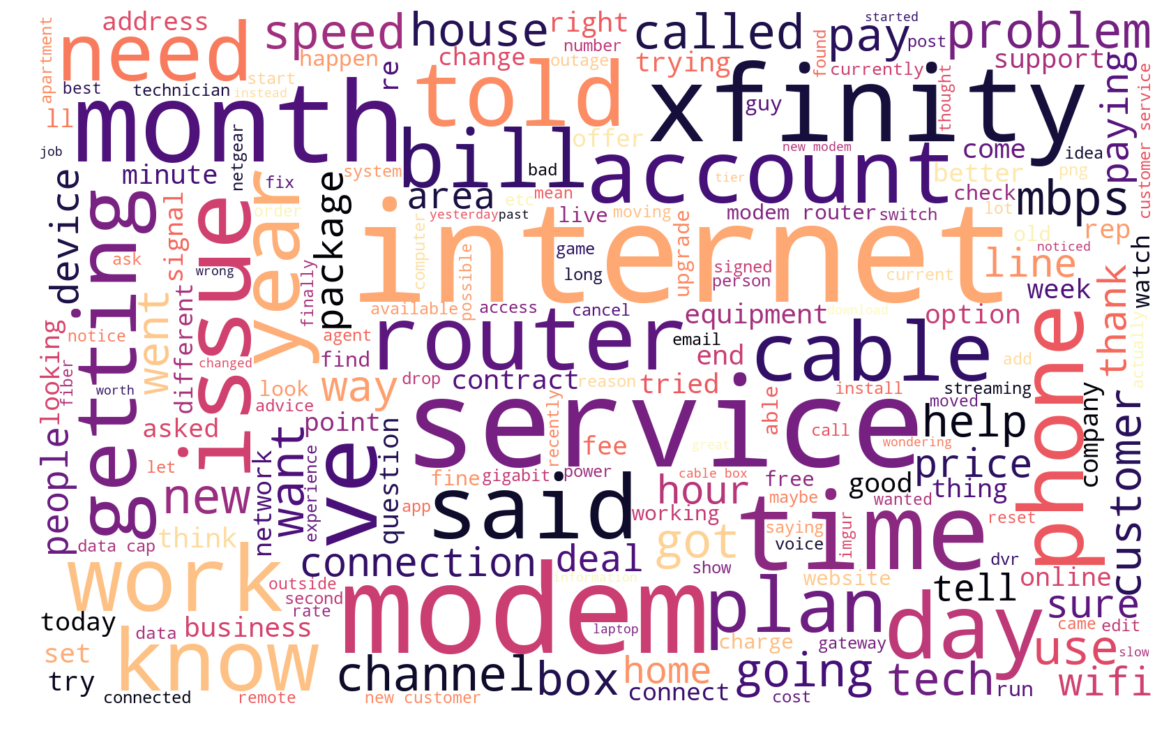

In [552]:
neg_tweets = all_df[all_df.subreddit == 0]
neg_string = []
for t in neg_tweets.post:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,max_font_size=200,colormap='magma',background_color='white').generate(neg_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()